# Dataset integration


In [1]:
import os
import pickle
os.chdir("../../")

import scanpy as sc

from Functions import immediate_early_pc, integrate_datasets, plot_loss

Global seed set to 0


<Figure size 72x72 with 0 Axes>


## General points
- All processing of the data is done primarily in functions to avoid overusing global variables

## Merge & Integration
- First the datasets are concatenated on the raw counts
- A subset is taken containing only neuronal cell types (Glu & Gaba)
- The first principal component of the immediate early genes is calculated
- The datsets are integrated using SCVI/SCANVI

In [2]:
def merge_datasets() -> sc.AnnData:
    all_datasets = [
        "Output/Data/1-FromRaw/Steuernagel2022.h5ad",
        "Output/Data/1-FromRaw/Lewis2020.h5ad",
        "Output/Data/1-FromRaw/Lopez2021.h5ad",
        "Output/Data/1-FromRaw/Short2021.h5ad",
        "Output/Data/1-FromRaw/Son2021.h5ad",
        "Output/Data/1-FromRaw/Xu2020.h5ad",
    ]
    # Merge datasets
    adata = sc.concat([sc.read_h5ad(ds) for ds in all_datasets], join = "outer")

    # Save raw counts
    adata.layers["counts"] = adata.X.copy().tocsr()

    # Filter for neuronal cells
    neuronal = [x in ["C7-1: GLU","C7-2: GABA", "NA"] for x in adata.obs["C7_named"]]
    adata = adata[neuronal, :].copy()

    # Drop column due to incompatibility with saving as h5ad
    adata.obs.drop(columns = "is_primary_data", inplace = True)

    return adata

adata = merge_datasets()
adata.obs["immediate_early"] = immediate_early_pc(adata)
adata.write_h5ad("Output/Data/2-Integration/1-Merged.h5ad")

In [3]:
scvae, scanvae = integrate_datasets(adata, n_genes = 2500)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [1:19:47<00:00, 11.97s/it, loss=803, v_num=1]
INFO     Training for 250 epochs.                                                            


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 215/250:  86%|████████▌ | 215/250 [1:50:30<17:59, 30.84s/it, loss=1.43e+03, v_num=1]
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 807.644. Signaling Trainer to stop.


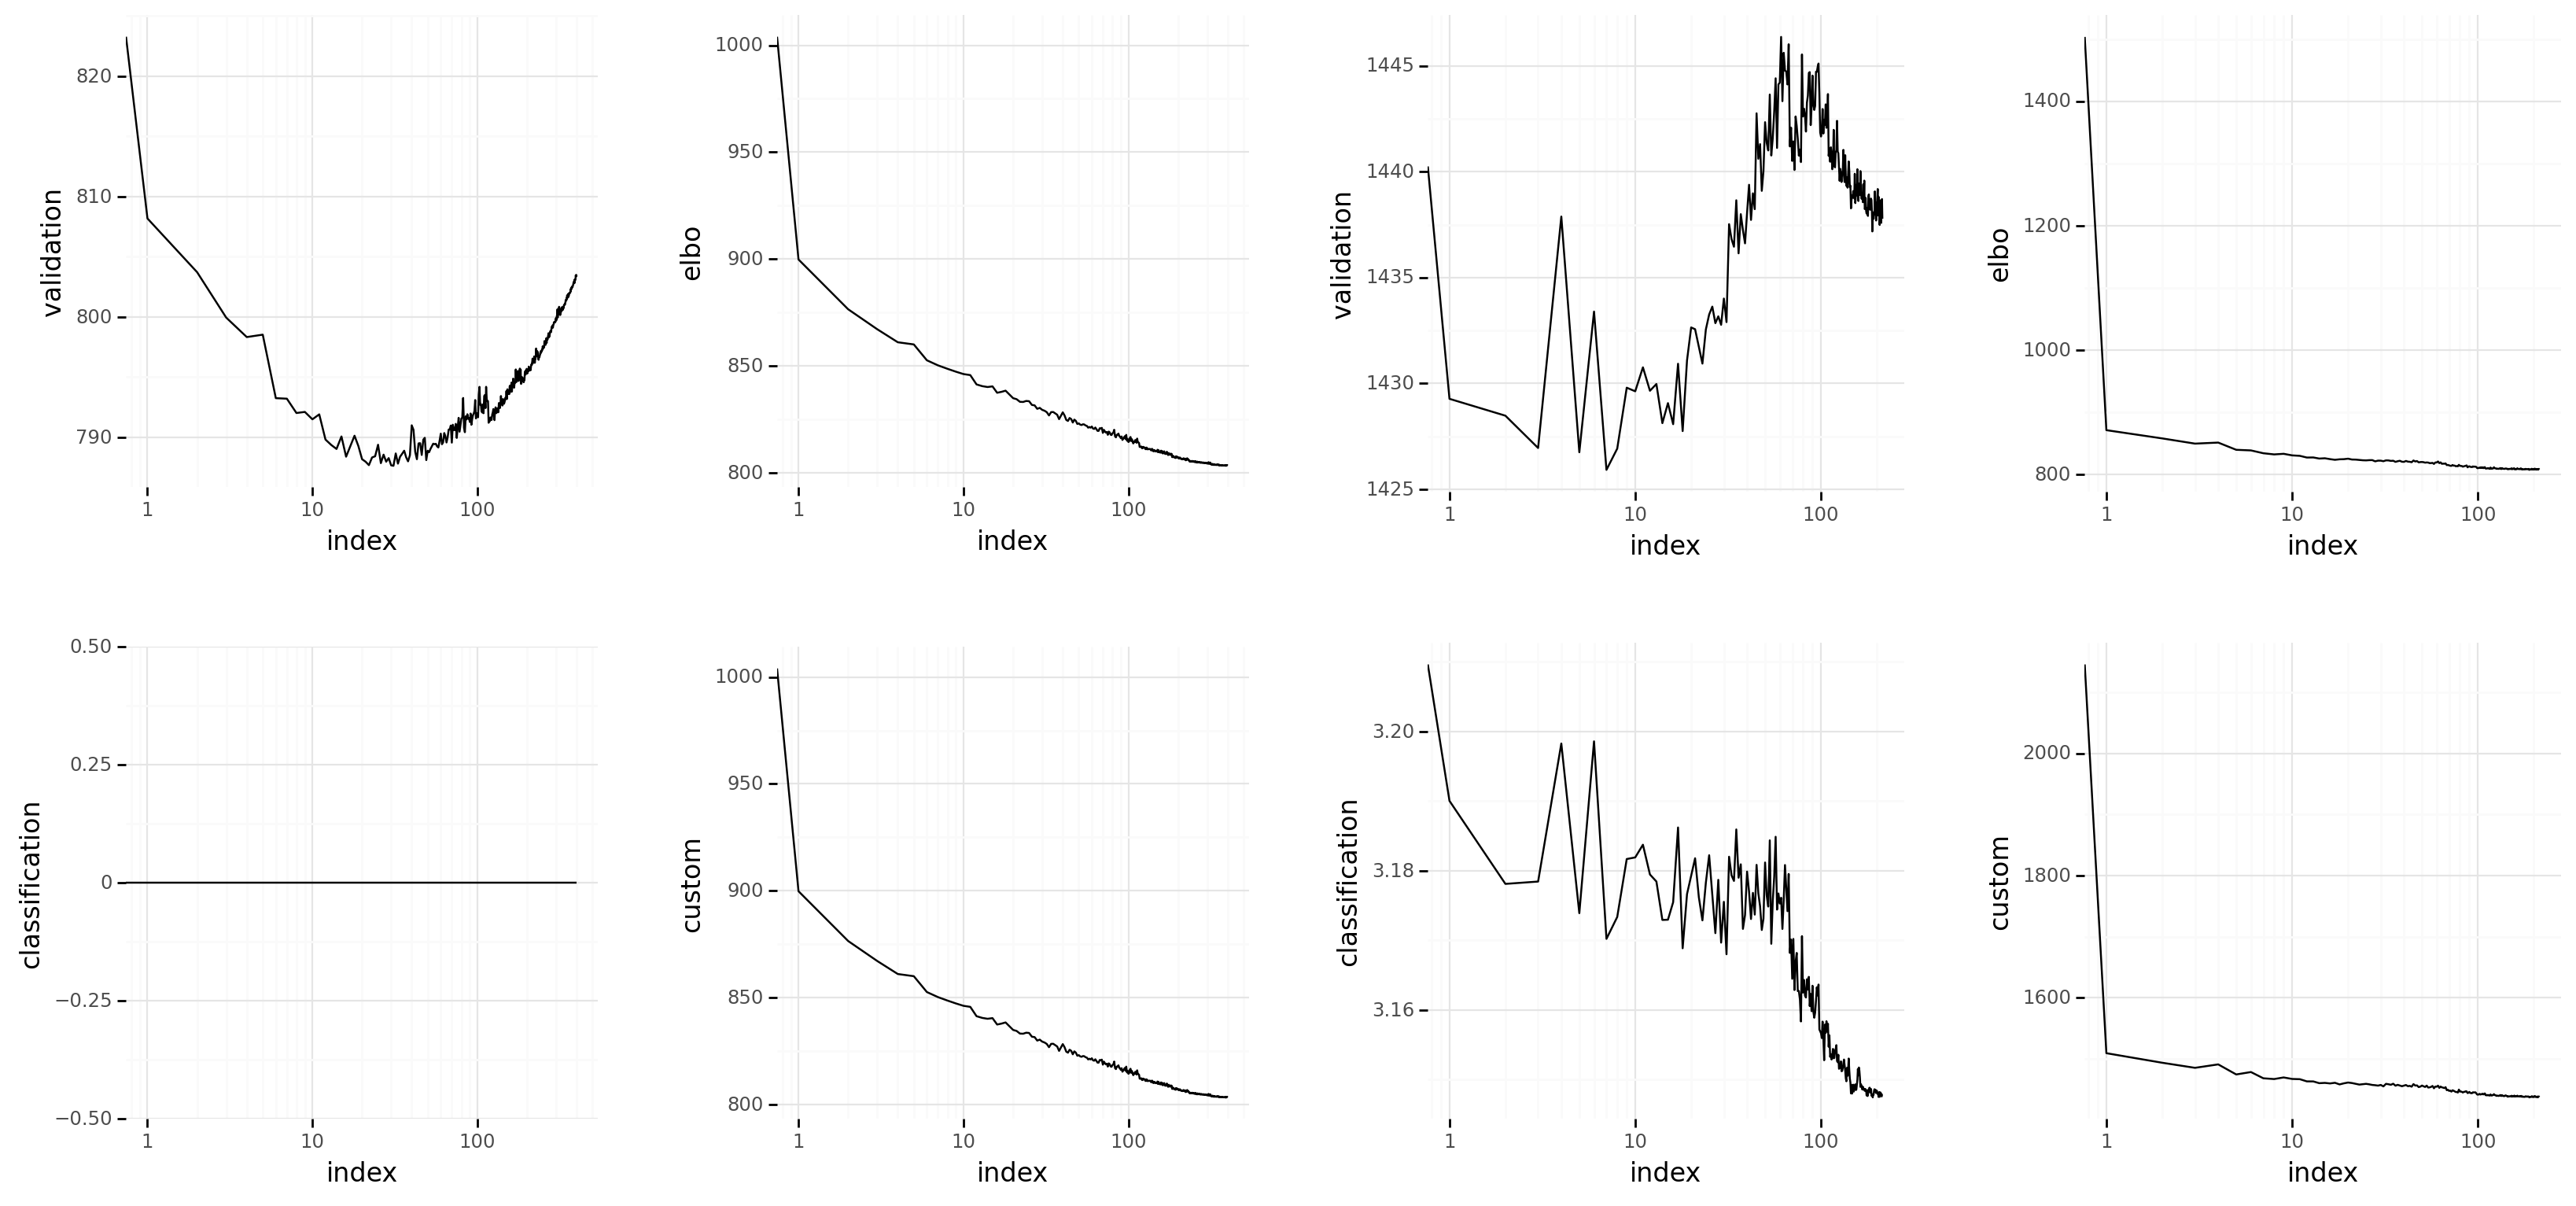

In [4]:
plot_loss(scvae) | plot_loss(scanvae)

In [5]:
with open(f"Output/Data/2-Integration/1-VAE.p", "wb") as f:
  pickle.dump((scvae, scanvae), f)